# Prepare Environment

Load necessary modules and attempt to compile the GrOpt library if it isn't already

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gropt
from helper_utils import *

%matplotlib inline

# GrOpt

### Gradient design toolbox 
#### Written in C (for compiling on scanners), with wrappers in Python and Matlab for prototyping

Ideally **_any_** waveform can be described by a set of constraints

Currently implemented in various forms on Siemens and GE scanners

***

## Example 1: Phase Encoding Gradient

#### Constraints on:
- Maximum gradient amplitude
- Maximum slew rate
- 0th moment = 11.74 (mT*ms)/m = The area needed to encode a 1mm spatial resolution line in k-space

Waveform duration = 0.63 ms


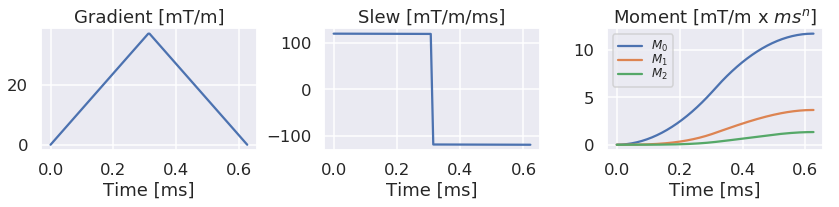

In [2]:
params = {}

params['mode'] = 'free' # Free mode indicates we are in a feasibility search, i.e. no objective function

# Set hardware limits
params['gmax'] = 0.05   # Maximum gradient amplitude, G/cm
params['smax'] = 120.0  # Maximum slew rate, mT/m/ms 

# Moment parameters have a lot of options, reading the docs is necessary
# Currently, the input moment parameters to know are: 
# 2nd (moment of interest, 0th), 6th (desired 0th moment, 11.75), and 7th (moment tolerance, 1.0e-3) 
params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]

params['dt'] = 4e-6 # Raster time of the gradient waveform being optimized


G, T_min = get_min_TE(params, max_TE = 2) # max_TE = 2 means it will search all waveforms between 0 and 2ms
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Reducing gmax to see its effect:

Waveform duration = 0.76 ms


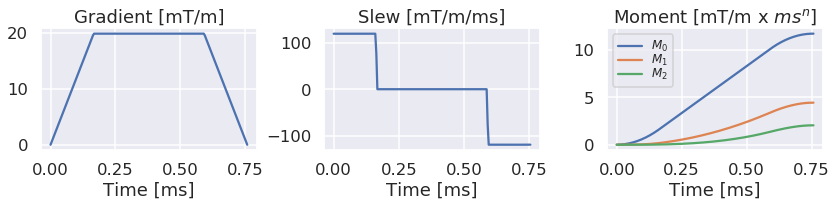

In [3]:
params = {}
params['mode'] = 'free'

# ************
# gmax changed to 20 mT/m 
# ************
params['gmax'] = 0.02
params['smax'] = 120.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Adding velocity compensation (add a constraint on M1 to be 0):

Waveform duration = 1.42 ms


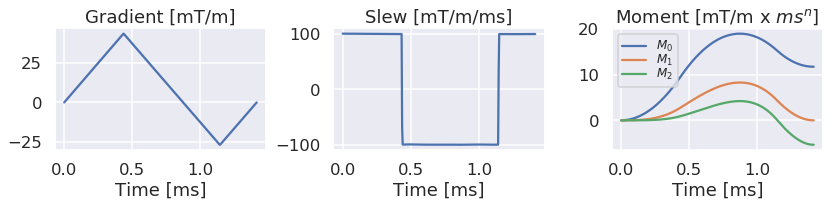

In [4]:
params = {}
params['mode'] = 'free'

params['gmax'] = 0.05
params['smax'] = 100.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
# ************
# Additional moment constraint added on M1 = 0
# ************
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2.5)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### Adding acceleration compensation (add a constraint on M2 to be 0):

Waveform duration = 2.35 ms


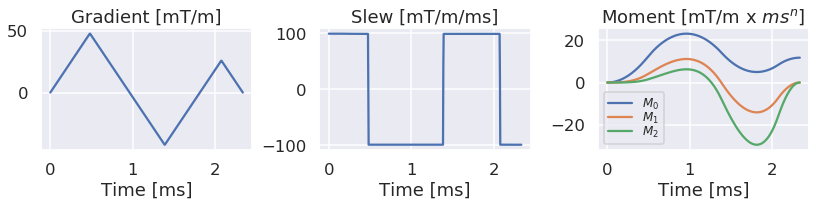

In [5]:
params = {}
params['mode'] = 'free'

params['gmax'] = 0.05
params['smax'] = 100.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
# ************
# Additional moment constraint added on M2 = 0
# ************
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2.6)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

### Peripheral Nerve Stimulation (PNS) control

If we use the full power of the gradient slew rates, the same gradient can be played much faster, but PNS will become problematic

Waveform duration = 1.72 ms


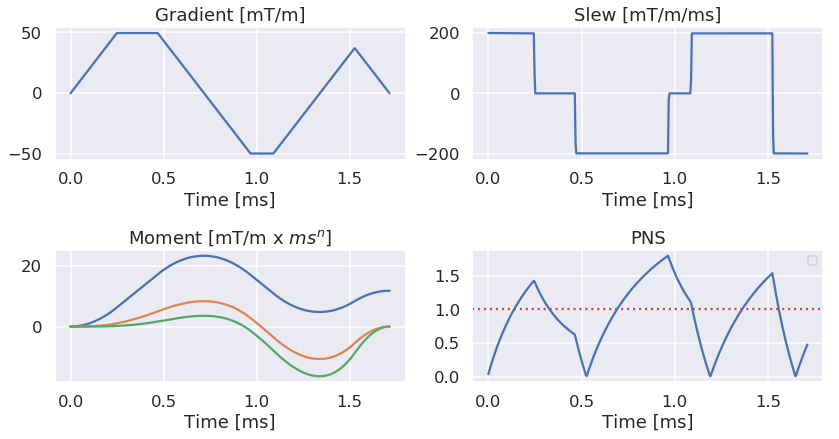

In [6]:
params = {}
params['mode'] = 'free'

params['gmax'] = 0.05
# ************
# Increases slew rate to 200
# ************
params['smax'] = 200.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 4e-6


G, T_min = get_min_TE(params, max_TE = 2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

#### We can keep the maximum slew rate (200mT/m/ms) and add a PNS constraint to keep PNS < 1.0

Waveform duration = 1.98 ms


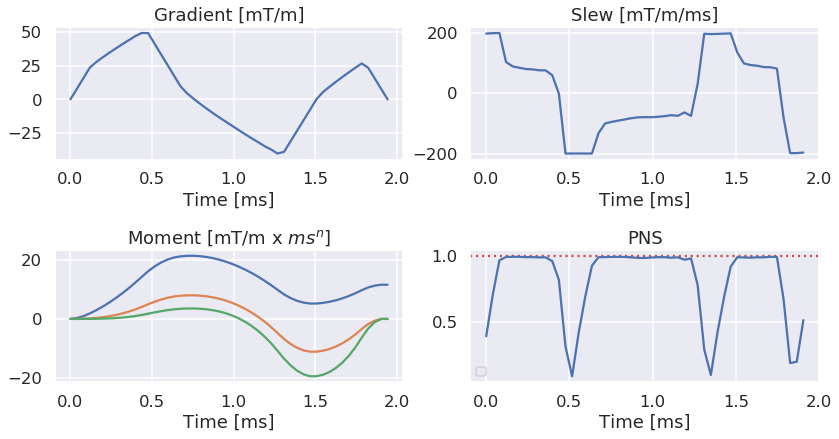

In [7]:
params = {}
params['mode'] = 'free'

params['gmax'] = 0.05
params['smax'] = 200.0

params['moment_params'] = [[0, 0, 0, -1, -1, 11.75, 1.0e-3]]
params['moment_params'].append([0, 1, 0, -1, -1, 0, 1.0e-3])
params['moment_params'].append([0, 2, 0, -1, -1, 0, 1.0e-3])
params['dt'] = 40e-6

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0

G, T_min = get_min_TE(params, min_TE = 1.6, max_TE = 2.2)
print('Waveform duration =', round(T_min,2), 'ms')
plot_waveform(G, params, plot_moments = True, plot_eddy = False, plot_pns = True, plot_slew = True)

## Example 2: Diffusion Encoding Gradients

#### Constraints on:
- Maximum gradient amplitude
- Maximum slew rate
- 0th moment = 0 (mT*ms)/m 
- Add objective function to maximize b-value
- Add constraint to turn gradients off during excitation and refocusing RF pulses
- Account for time spent readout out the data (immiedatley after diffusion gradients until the echo time)

Minimum TE = 63.91 ms


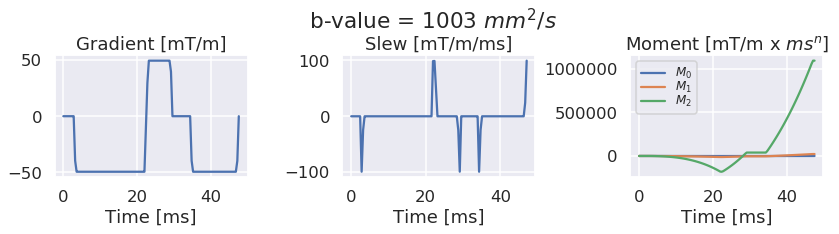

In [8]:
params = {}
# ************
# Objective function now maximized b-value, also allows some shorthand for rf, moment nulling, and readout TE
# ************
params['mode'] = 'diff_bval'
# ************
# Short hand for moment nulling of M0
# ************
params['MMT'] = 0

params['gmax'] = 0.05
params['smax'] = 100.0

# ************
# Constraints define RF gradient dead times, and the time to TE after diffusion encoding [in ms]
# ************
params['T_readout'] = 16.0
params['T_90'] = 3
params['T_180'] = 5

# ************
# Waveforms are much longer, but we can also get away with much higher dt to keep compute times fast
# ************
params['dt'] = 400e-6

# ************
# b-value = 1000 is selected here
# ************
bval = 1000


G_min, T_min = get_min_TE(params, bval, min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### We can constrain for M0=M1=0 

Minimum TE = 89.3 ms


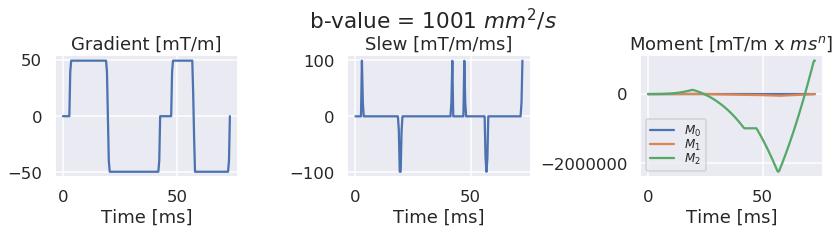

In [9]:
params = {}
params['mode'] = 'diff_bval'
# ************
# M0 and M1 nulling
# ************
params['MMT'] = 1
params['gmax'] = 0.05
params['smax'] = 100.0
params['T_readout'] = 16.0
params['T_90'] = 3
params['T_180'] = 5
params['dt'] = 400e-6
bval = 1000


G_min, T_min = get_min_TE(params, bval, min_TE = 80, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### We can constrain for M0=M1=M2= 0 

Minimum TE = 106.56 ms


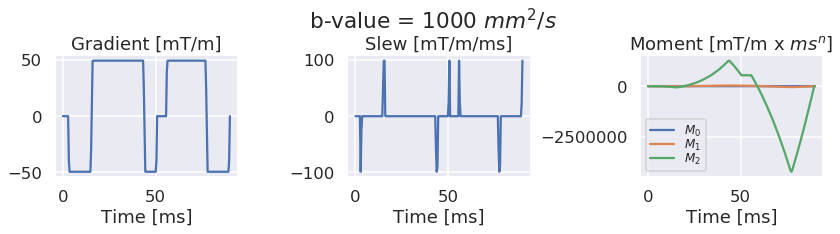

In [10]:
params = {}
params['mode'] = 'diff_bval'
# ************
# M0, M1 and M2 nulling
# ************
params['MMT'] = 2
params['gmax'] = 0.05
params['smax'] = 100.0
params['T_readout'] = 16.0
params['T_90'] = 3
params['T_180'] = 5
params['dt'] = 400e-6
bval = 1000


G_min, T_min = get_min_TE(params, bval, min_TE = 80, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = True, plot_eddy = False, plot_pns = False, plot_slew = True)

#### We can also constrain PNS for diffusion

In [11]:
params = {}
params['mode'] = 'diff_bval'
params['MMT'] = 0
params['gmax'] = 0.05

# ************
# Use maximum slew rate
# ************
params['smax'] = 200.0

params['T_readout'] = 16.0
params['T_90'] = 3
params['T_180'] = 5
params['dt'] = 400e-6
bval = 1000

# ************
# Add PNS contraint
# ************
params['pns_thresh'] = 1.0


G_min, T_min = get_min_TE(params, bval, min_TE = 40, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = False, plot_eddy = False, plot_pns = True, plot_slew = True)

UnboundLocalError: local variable 'T_out' referenced before assignment

#### We can also constrain to null for a specific eddy current time constants (lambda) to ensure eddy currents are nulled

In [ ]:
params = {}
params['mode'] = 'diff_bval'
params['MMT']  = 0
params['gmax']  = 0.05
params['smax']  = 100.0
params['T_readout']  = 16.0
params['T_90']  = 3
params['T_180']  = 5
params['dt']  = 400e-6
bval = 1000

# ************
# Null eddy current for lambda time constant = 60ms
# ************
params['eddy_params']  = [[60.0, 0.0, 1.0e-4, 0.0]]

G_min, T_min = get_min_TE(params, bval, min_TE = 80, max_TE = 120)
print('Minimum TE =', round(T_min,2), 'ms')
plot_waveform(G_min, params, plot_moments = False, plot_eddy = True, plot_pns = False, plot_slew = True)